In [19]:
import random
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
!pip install dimod
import dimod

In [20]:
num_agents = 100
total_rounds = 1000
compromise_rate = 0.10
penalty = 0.05
reward = 0.02
use_countermeasures = True  # << Toggle True/False here to test defense vs no defense

# Initialize robot data
robots = {}
for i in range(1, num_agents + 1):
    robot_id = f"Robot_{i}"
    initial_trust = round(random.uniform(0.3, 0.95), 2)
    robots[robot_id] = {
        'trust': initial_trust,
        'trust_history': [initial_trust],
        'compromised': False,
        'success_count': 0,
        'fail_count': 0
    }

print(f"✅ Initialized {num_agents} robots with random trust scores between 0.3 and 0.95.")


✅ Initialized 100 robots with random trust scores between 0.3 and 0.95.


In [21]:
# Logs for analysis
compromised_counts = []
success_counts = []
fail_counts = []

In [22]:
# --- Main Simulation Loop ---
for round_num in range(total_rounds):

    # Randomly choose ~10% of robots to compromise
    num_compromised = int(num_agents * compromise_rate)
    compromised_ids = random.sample(list(robots.keys()), num_compromised)

    # Round counters
    round_compromised = 0
    round_success = 0
    round_fail = 0

    for robot_id in robots:
        robot = robots[robot_id]
        robot['compromised'] = robot_id in compromised_ids

        if robot['compromised']:
            round_compromised += 1
            robot['fail_count'] += 1
            robot['trust'] = max(0.0, robot['trust'] - penalty)
        else:
            if random.random() < robot['trust']:
                round_success += 1
                robot['success_count'] += 1
                robot['trust'] = min(1.0, robot['trust'] + reward)
            else:
                round_fail += 1
                robot['fail_count'] += 1
                robot['trust'] = max(0.0, robot['trust'] - penalty)

        # === Apply Countermeasures if enabled ===
        if use_countermeasures:
            # Recovery if they have been consistently successful
            if robot['success_count'] > 5 and robot['trust'] < 0.9:
                robot['trust'] += 0.01

            # Trust floor every 200 rounds
            if round_num % 200 == 0:
                robot['trust'] = max(robot['trust'], 0.2)

            # OPTIONAL: Skip assignment for very low-trust robots
            # if robot['trust'] < 0.2:
            #     continue

        # Log this round's trust
        robot['trust_history'].append(robot['trust'])

    # Record round-level stats
    compromised_counts.append(round_compromised)
    success_counts.append(round_success)
    fail_counts.append(round_fail)

print(f"✅ Finished {total_rounds} simulation rounds!")

✅ Finished 1000 simulation rounds!


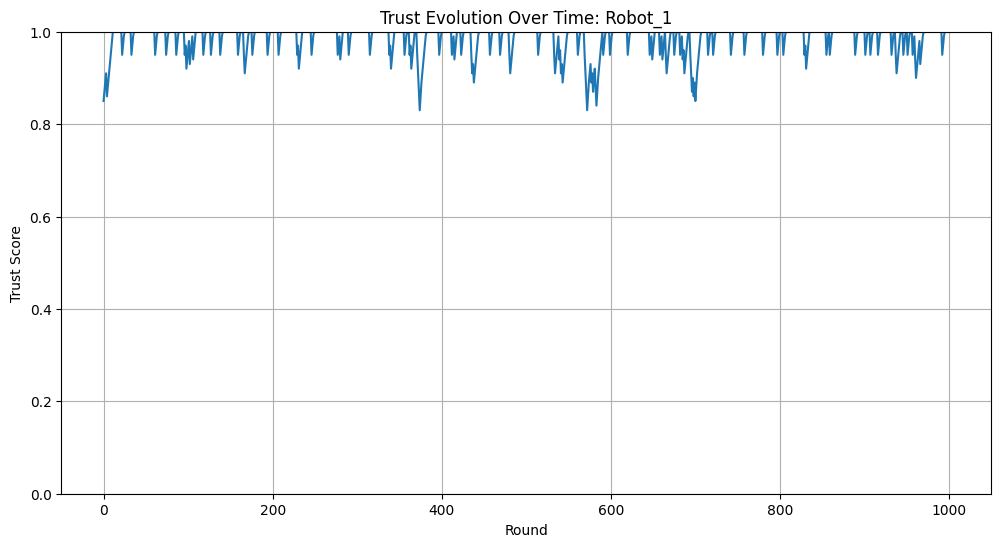

In [23]:
example_robot_id = "Robot_1"
plt.figure(figsize=(12,6))
plt.plot(robots[example_robot_id]['trust_history'])
plt.title(f"Trust Evolution Over Time: {example_robot_id}")
plt.xlabel("Round")
plt.ylabel("Trust Score")
plt.ylim(0, 1)
plt.grid()
plt.show()

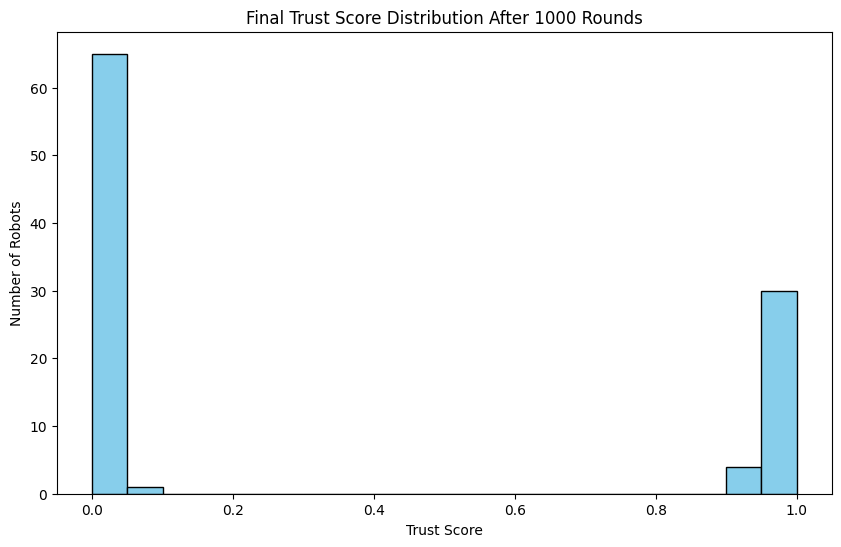

In [24]:
final_trust_scores = [robots[robot_id]['trust'] for robot_id in robots]
plt.figure(figsize=(10,6))
plt.hist(final_trust_scores, bins=20, color='skyblue', edgecolor='black')
plt.title("Final Trust Score Distribution After 1000 Rounds")
plt.xlabel("Trust Score")
plt.ylabel("Number of Robots")
plt.show()

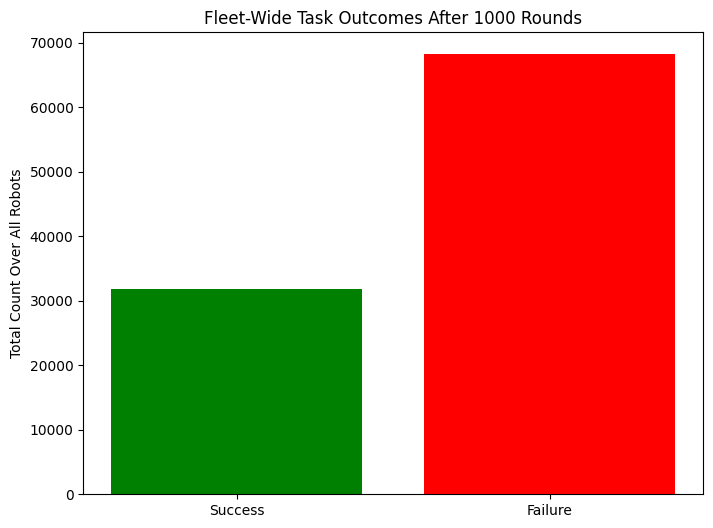

✅ Total Successes: 31776
✅ Total Failures: 68224


In [25]:
total_success = sum(robots[robot_id]['success_count'] for robot_id in robots)
total_fail = sum(robots[robot_id]['fail_count'] for robot_id in robots)

plt.figure(figsize=(8,6))
plt.bar(['Success', 'Failure'], [total_success, total_fail], color=['green', 'red'])
plt.title("Fleet-Wide Task Outcomes After 1000 Rounds")
plt.ylabel("Total Count Over All Robots")
plt.show()

print(f"✅ Total Successes: {total_success}")
print(f"✅ Total Failures: {total_fail}")


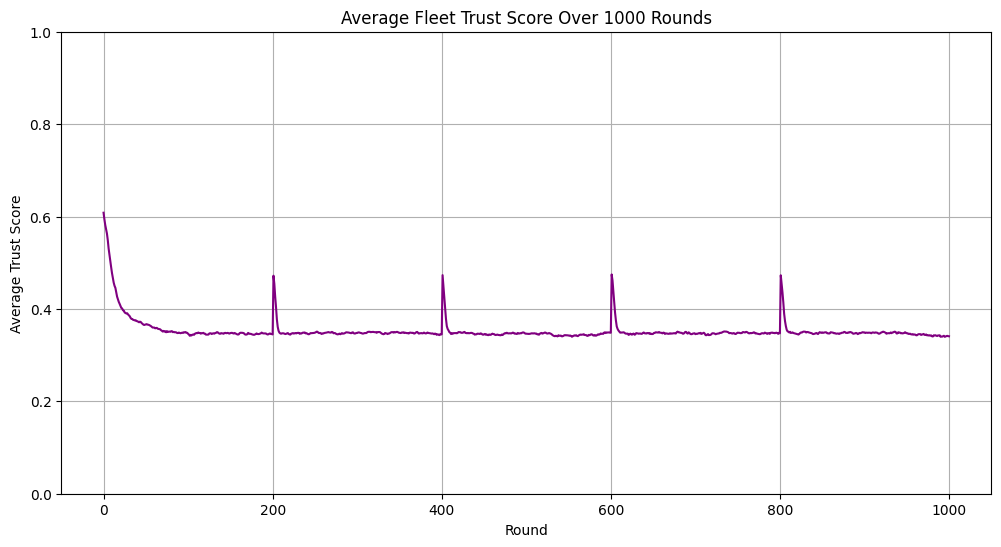

In [26]:
rounds = len(next(iter(robots.values()))['trust_history'])
average_trust_per_round = []
for round_idx in range(rounds):
    avg = np.mean([robots[robot_id]['trust_history'][round_idx] for robot_id in robots])
    average_trust_per_round.append(avg)

plt.figure(figsize=(12,6))
plt.plot(range(rounds), average_trust_per_round, color='purple')
plt.title("Average Fleet Trust Score Over 1000 Rounds")
plt.xlabel("Round")
plt.ylabel("Average Trust Score")
plt.ylim(0, 1)
plt.grid()
plt.show()

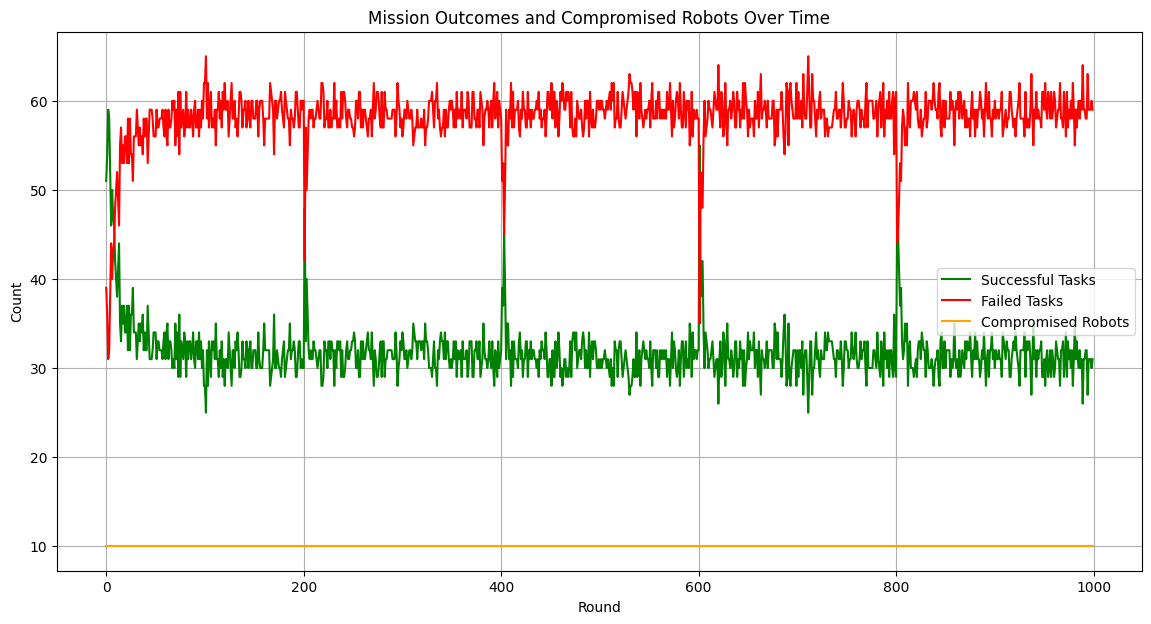

In [27]:
plt.figure(figsize=(14,7))
plt.plot(range(total_rounds), success_counts, label='Successful Tasks', color='green')
plt.plot(range(total_rounds), fail_counts, label='Failed Tasks', color='red')
plt.plot(range(total_rounds), compromised_counts, label='Compromised Robots', color='orange')
plt.title("Mission Outcomes and Compromised Robots Over Time")
plt.xlabel("Round")
plt.ylabel("Count")
plt.legend()
plt.grid()
plt.show()

In [28]:
# === Build Agent-Task Trust Matrix ===
agent_trust_vector = np.array([robots[robot_id]['trust'] for robot_id in robots])
num_tasks = 100

# Simulate task difficulty
task_difficulty_vector = np.random.uniform(0.8, 1.0, size=num_tasks)

# Full 100x100 agent-task trust matrix
trust_matrix_full = np.outer(agent_trust_vector, task_difficulty_vector)
print("✅ Built Agent-Task Trust Matrix:", trust_matrix_full.shape)



✅ Built Agent-Task Trust Matrix: (100, 100)


In [37]:
# === Sample 5x5 Submatrix for QUBO Demonstration ===
num_agents_qubo = 5
num_tasks_qubo = 5

agents_indices = np.random.choice(range(num_agents), num_agents_qubo, replace=False)
tasks_indices = np.random.choice(range(num_tasks), num_tasks_qubo, replace=False)

trust_matrix_qubo = trust_matrix_full[np.ix_(agents_indices, tasks_indices)]
print("5x5 Trust Matrix for QUBO")
print(trust_matrix_qubo)



5x5 Trust Matrix for QUBO
[[0.00837042 0.00910393 0.00915628 0.00866591 0.00888064]
 [0.00837042 0.00910393 0.00915628 0.00866591 0.00888064]
 [0.00837042 0.00910393 0.00915628 0.00866591 0.00888064]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


In [38]:
# === Simulate Poisoning ===
poisoned_trust_matrix_qubo = trust_matrix_qubo.copy()
poisoned_trust_matrix_qubo[2, :] -= 0.4
poisoned_trust_matrix_qubo = np.clip(poisoned_trust_matrix_qubo, 0, 1)
print("Poisoned Trust Matrix")
print(poisoned_trust_matrix_qubo)



Poisoned Trust Matrix
[[0.00837042 0.00910393 0.00915628 0.00866591 0.00888064]
 [0.00837042 0.00910393 0.00915628 0.00866591 0.00888064]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.        ]]


In [39]:
# === Apply Simple Defense ===
defense_trust_matrix_qubo = poisoned_trust_matrix_qubo.copy()
for i in range(num_agents_qubo):
    for j in range(num_tasks_qubo):
        if defense_trust_matrix_qubo[i, j] < 0.3:
            defense_trust_matrix_qubo[i, j] += 0.2
defense_trust_matrix_qubo = np.clip(defense_trust_matrix_qubo, 0, 1)
print("Defended Trust Matrix")
print(defense_trust_matrix_qubo)

Defended Trust Matrix
[[0.20837042 0.20910393 0.20915628 0.20866591 0.20888064]
 [0.20837042 0.20910393 0.20915628 0.20866591 0.20888064]
 [0.2        0.2        0.2        0.2        0.2       ]
 [0.2        0.2        0.2        0.2        0.2       ]
 [0.2        0.2        0.2        0.2        0.2       ]]


In [32]:
# === Rescale Trust Matrices ===
scale_factor = 20
trust_matrix_qubo_rescaled = trust_matrix_qubo * scale_factor
poisoned_trust_matrix_qubo_rescaled = poisoned_trust_matrix_qubo * scale_factor
defense_trust_matrix_qubo_rescaled = defense_trust_matrix_qubo * scale_factor

In [33]:
# === Build QUBO Function (With Encouragement) ===
def build_qubo(trust_matrix, lambda_penalty=1.0, encouragement=0.5):
    num_agents, num_tasks = trust_matrix.shape
    N = num_agents * num_tasks
    qubo = np.zeros((N, N))

    # Objective: maximize trust + encouragement bias
    for i in range(num_agents):
        for j in range(num_tasks):
            idx = i * num_tasks + j
            qubo[idx, idx] = -trust_matrix[i, j] - encouragement

    # Constraint: one task per agent
    for i in range(num_agents):
        for j1 in range(num_tasks):
            for j2 in range(j1 + 1, num_tasks):
                idx1 = i * num_tasks + j1
                idx2 = i * num_tasks + j2
                qubo[idx1, idx2] += lambda_penalty
                qubo[idx1, idx1] += lambda_penalty
                qubo[idx2, idx2] += lambda_penalty

    # Constraint: one agent per task
    for j in range(num_tasks):
        for i1 in range(num_agents):
            for i2 in range(i1 + 1, num_agents):
                idx1 = i1 * num_tasks + j
                idx2 = i2 * num_tasks + j
                qubo[idx1, idx2] += lambda_penalty
                qubo[idx1, idx1] += lambda_penalty
                qubo[idx2, idx2] += lambda_penalty

    return qubo

In [34]:
# === Solve QUBO ===
def solve_qubo(qubo):
    bqm = dimod.BinaryQuadraticModel.from_qubo(qubo)
    sampler = dimod.ExactSolver()
    solution = sampler.sample(bqm)
    best_sample = next(iter(solution))
    return best_sample

def decode_solution(best_sample, num_agents, num_tasks):
    assignment = np.zeros((num_agents, num_tasks), dtype=int)
    for i in range(num_agents):
        for j in range(num_tasks):
            idx = i * num_tasks + j
            assignment[i, j] = best_sample[idx]
    return assignment


In [42]:
# === Run QUBO Optimization ===
lambda_penalty = 1.0
encouragement = 0.5

# Poisoned
qubo_poisoned = build_qubo(poisoned_trust_matrix_qubo_rescaled, lambda_penalty, encouragement)
sol_poisoned = solve_qubo(qubo_poisoned)
assign_poisoned = decode_solution(sol_poisoned, num_agents_qubo, num_tasks_qubo)

# Defended
qubo_defended = build_qubo(defense_trust_matrix_qubo_rescaled, lambda_penalty, encouragement)
sol_defended = solve_qubo(qubo_defended)
assign_defended = decode_solution(sol_defended, num_agents_qubo, num_tasks_qubo)

print("QUBO Assignment (Poisoned)")
print(assign_poisoned)
print("QUBO Assignment (Defended)")
print(assign_defended)



QUBO Assignment (Poisoned)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 1 1 1]]
QUBO Assignment (Defended)
[[1 1 1 1 1]
 [1 1 1 1 1]
 [0 0 0 0 0]
 [0 0 0 0 0]
 [1 1 1 1 1]]


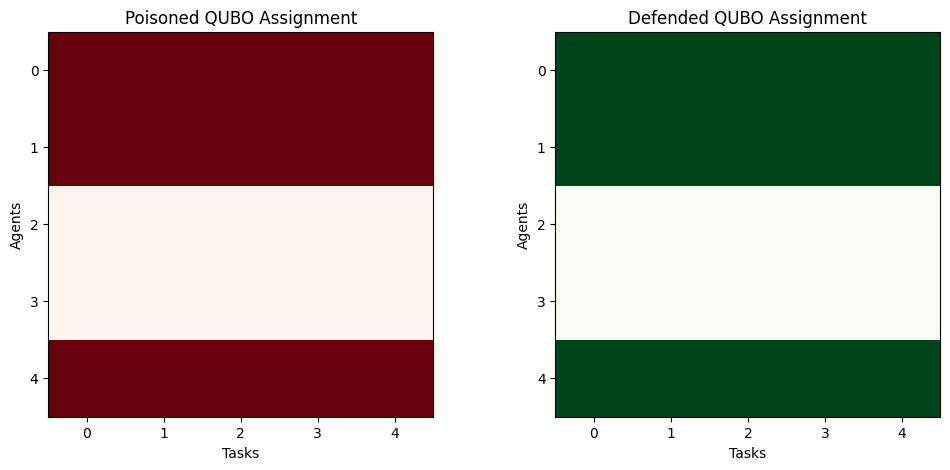

In [36]:
# === Visualize Assignments ===
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(assign_poisoned, cmap='Reds')
plt.title('Poisoned QUBO Assignment')
plt.xlabel('Tasks')
plt.ylabel('Agents')

plt.subplot(1,2,2)
plt.imshow(assign_defended, cmap='Greens')
plt.title('Defended QUBO Assignment')
plt.xlabel('Tasks')
plt.ylabel('Agents')
plt.show()

